In [1]:
import xarray as xr
from ndpyramid.utils import set_zarr_encoding
import numpy as np


In [2]:
url = "s3://carbonplan-oae-efficiency/v2/store1b_rechunked.zarr/"
current = xr.open_dataset(url, engine='zarr', chunks={})
current

<xarray.Dataset> Size: 3MB
Dimensions:         (elapsed_time: 180, polygon_id: 690, injection_date: 4,
                     nlat: 384, nlon: 320)
Coordinates:
    TAREA           (nlat, nlon) float64 983kB dask.array<chunksize=(384, 320), meta=np.ndarray>
    dz              float32 4B ...
  * elapsed_time    (elapsed_time) float64 1kB 0.0 1.0 2.0 ... 177.0 178.0 179.0
  * injection_date  (injection_date) float64 32B 1.0 4.0 7.0 10.0
  * polygon_id      (polygon_id) float64 6kB 0.0 1.0 2.0 ... 687.0 688.0 689.0
Dimensions without coordinates: nlat, nlon
Data variables:
    OAE_efficiency  (elapsed_time, polygon_id, injection_date) float32 2MB dask.array<chunksize=(180, 690, 1), meta=np.ndarray>
Attributes:
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    calendar:          All years have exactly  365 days.
    cell_methods:      cell_methods = time: mean ==> the variable values are ...
    contents:          Diagnostic and Prognostic Variables
    history:           none
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    revision:          $Id$
    source:            CCSM POP2, the CCSM Ocean Component
    start_time:        This dataset was created on 2023-05-29 at 09:20:38.7
    time_period_freq:  month_1
    title:             smyle-fosi.North_Atlantic_basin.alk-forcing-North_Atla...

In [3]:
path = '/global/homes/a/abanihi/OAE_efficiency_corrected_.nc'
raw_ds = xr.open_dataset(path)
raw_ds

<xarray.Dataset> Size: 7MB
Dimensions:         (region: 4, season: 4, polygon: 300, time: 189)
Coordinates:
  * region          (region) <U14 224B 'Pacific' 'Atlantic' ... 'Southern_Ocean'
  * season          (season) <U7 112B 'January' 'April' 'July' 'October'
  * polygon         (polygon) int64 2kB 0 1 2 3 4 5 ... 294 295 296 297 298 299
  * time            (time) object 2kB 0347-01-16 12:00:00 ... 0362-09-16 00:0...
Data variables:
    OAE_efficiency  (region, season, polygon, time) float64 7MB ...

In [4]:
def break_into_seasons(ds, *, polygon:int=0, region:int=0):
    jan = ds.isel(polygon=polygon, region=region, season=0)
    apr = ds.isel(polygon=polygon, region=region, season=1)
    jul = ds.isel(polygon=polygon, region=region, season=2)
    octo = ds.isel(polygon=polygon, region=region, season=3)

    results = {'january': jan.where(jan.OAE_efficiency.notnull(), drop=True), 
               'april': apr.where(apr.OAE_efficiency.notnull(), drop=True), 
               'july': jul.where(jul.OAE_efficiency.notnull(), drop=True),
               'october': octo.where(octo.OAE_efficiency.notnull(), drop=True)}
    return results

In [5]:
datasets = break_into_seasons(raw_ds)
datasets

{'january': <xarray.Dataset> Size: 3kB
 Dimensions:         (time: 180)
 Coordinates:
     region          <U14 56B 'Pacific'
     season          <U7 28B 'January'
     polygon         int64 8B 0
   * time            (time) object 1kB 0347-01-16 12:00:00 ... 0361-12-16 12:0...
 Data variables:
     OAE_efficiency  (time) float64 1kB 0.03391 0.08991 0.1478 ... 0.8193 0.8194,
 'april': <xarray.Dataset> Size: 3kB
 Dimensions:         (time: 180)
 Coordinates:
     region          <U14 56B 'Pacific'
     season          <U7 28B 'April'
     polygon         int64 8B 0
   * time            (time) object 1kB 0347-04-16 00:00:00 ... 0362-03-16 12:0...
 Data variables:
     OAE_efficiency  (time) float64 1kB 0.0245 0.05309 0.0858 ... 0.8213 0.8215,
 'july': <xarray.Dataset> Size: 3kB
 Dimensions:         (time: 180)
 Coordinates:
     region          <U14 56B 'Pacific'
     season          <U7 28B 'July'
     polygon         int64 8B 0
   * time            (time) object 1kB 0347-07-16 12:00:00

In [6]:
# fig, ax = plt.subplots(figsize=(12, 6))
# # Define colors and offsets for each season
# colors = ['blue', 'green', 'red', 'orange']
# offsets = [0.8, 0.6, 0.4, 0.2]  # For spacing the seasons vertically

# # Plot each season as a line with points
# for i, (season, times) in enumerate(datasets.items()):
#     ax.scatter(times, [offsets[i]] * len(times), 
#              color=colors[i], alpha=0.7, label=season)
    
#     # Connect points with lines
#     ax.plot(times, [offsets[i]] * len(times), 
#            color=colors[i], alpha=0.3, linewidth=2)

# # Add vertical lines at points of overlap
# all_times = np.concatenate([times for times in datasets.values()])
# unique_times = np.unique(all_times)

# # Count occurrences of each time point
# time_counts = {}
# for t in all_times:
#     time_counts[t] = time_counts.get(t, 0) + 1

# # Highlight overlaps
# for t, count in time_counts.items():
#     if count > 1:  # If time appears in more than one season
#         ax.axvline(x=t, color='purple', alpha=0.3 * count/4, 
#                   linestyle='--', linewidth=count)

# # Format the plot
# ax.set_yticks(offsets)
# ax.set_yticklabels(['January', 'April', 'July', 'October'])
# ax.set_title('Time Overlaps Between Seasons')

# # Format x-axis to show dates properly
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
# plt.xticks(rotation=45)

# ax.grid(True, axis='x', alpha=0.3)
# ax.legend(loc='upper right')

# plt.tight_layout()

In [7]:
def combine_seasons_with_relative_time(season_dict):
    """
    Combine season datasets using a relative time approach.
    
    Parameters:
    -----------
    season_dict : dict
        Dictionary with keys as season names and values as xarray Datasets
        Each dataset should have 180 time points
        
    Returns:
    --------
    xarray.Dataset
        Combined dataset with a single time dimension of 180 points
    """
    with xr.set_options(keep_attrs=True):
        # First, let's create a common time coordinate based on "months since injection"
        relative_months = np.arange(180).astype('int32')
        
        # Create a new dataset for each season with standardized coordinates
        standardized_datasets = []
        
        for season_name, ds in season_dict.items():
            # Create a new dataset with the original data but new coordinates
            new_ds = xr.Dataset(
                data_vars={
                    'OAE_efficiency': ('elapsed_time', ds.OAE_efficiency.data)
                },
                coords={
                    'elapsed_time': relative_months,
                    #'original_time': ('elapsed_months', ds.time.values)  # Keep original time as a coordinate
                }
            )
            
            # Extract the first time point as the injection date
            new_ds = new_ds.assign_coords(injection_date=ds.time.values[0].month)
            
            standardized_datasets.append(new_ds)
        
        # Combine using multi-index approach
        combined = xr.concat(standardized_datasets, dim='injection_date').expand_dims({'polygon': [ds.polygon.values], 'region': [ds.region.values]})
    
    return combined

In [8]:
combine_seasons_with_relative_time(datasets)#.OAE_efficiency.plot(col='injection_date')

<xarray.Dataset> Size: 7kB
Dimensions:         (polygon: 1, region: 1, injection_date: 4, elapsed_time: 180)
Coordinates:
  * polygon         (polygon) int64 8B 0
  * region          (region) object 8B 'Pacific'
  * elapsed_time    (elapsed_time) int32 720B 0 1 2 3 4 ... 175 176 177 178 179
  * injection_date  (injection_date) int64 32B 1 4 7 10
Data variables:
    OAE_efficiency  (polygon, region, injection_date, elapsed_time) float64 6kB ...

In [9]:
dsets = []
for polygon in range(len(raw_ds.polygon)):
    for region in range(len(raw_ds.region)):
        parts = break_into_seasons(raw_ds, polygon=polygon, region=region)
        if len(parts['january'].time) == 180:
            data = combine_seasons_with_relative_time(parts)
            dsets.append(data)
ds = xr.combine_by_coords(dsets)
ds

<xarray.Dataset> Size: 7MB
Dimensions:         (polygon: 300, region: 4, injection_date: 4,
                     elapsed_time: 180)
Coordinates:
  * polygon         (polygon) int64 2kB 0 1 2 3 4 5 ... 294 295 296 297 298 299
  * elapsed_time    (elapsed_time) int32 720B 0 1 2 3 4 ... 175 176 177 178 179
  * injection_date  (injection_date) int64 32B 1 4 7 10
  * region          (region) object 32B 'Atlantic' ... 'Southern_Ocean'
Data variables:
    OAE_efficiency  (polygon, region, injection_date, elapsed_time) float64 7MB ...

In [10]:
atlantic = ds.sel(region='Atlantic').isel(polygon=slice(0, 150))
pacific = ds.sel(region='Pacific').isel(polygon=slice(0, 200))
south_atlantic = ds.sel(region='South').isel(polygon=slice(0, 300))
southern = ds.sel(region='Southern_Ocean').isel(polygon=slice(0, 40))

In [11]:
atlantic

<xarray.Dataset> Size: 866kB
Dimensions:         (polygon: 150, injection_date: 4, elapsed_time: 180)
Coordinates:
  * polygon         (polygon) int64 1kB 0 1 2 3 4 5 ... 144 145 146 147 148 149
  * elapsed_time    (elapsed_time) int32 720B 0 1 2 3 4 ... 175 176 177 178 179
  * injection_date  (injection_date) int64 32B 1 4 7 10
    region          <U8 32B 'Atlantic'
Data variables:
    OAE_efficiency  (polygon, injection_date, elapsed_time) float64 864kB 0.0...

In [12]:
dset = xr.concat([atlantic, pacific, south_atlantic, southern], dim='polygon').drop_vars('region')
dset = dset.rename_vars({'polygon': 'polygon_id'}).swap_dims({'polygon': 'polygon_id'}).transpose('elapsed_time', 'polygon_id', 'injection_date')
dset['polygon_id'] = np.arange(0, 690, dtype=np.int32)
dset = set_zarr_encoding(dset, float_dtype='float32', int_dtype='int32').chunk({'injection_date': 1})
dset

<xarray.Dataset> Size: 2MB
Dimensions:         (elapsed_time: 180, polygon_id: 690, injection_date: 4)
Coordinates:
  * polygon_id      (polygon_id) int32 3kB 0 1 2 3 4 5 ... 685 686 687 688 689
  * elapsed_time    (elapsed_time) int32 720B 0 1 2 3 4 ... 175 176 177 178 179
  * injection_date  (injection_date) int32 16B 1 4 7 10
Data variables:
    OAE_efficiency  (elapsed_time, polygon_id, injection_date) float32 2MB dask.array<chunksize=(180, 690, 1), meta=np.ndarray>

In [13]:
%%time
dset.to_zarr("s3://carbonplan-oae-efficiency/v3/store1b.zarr/", consolidated=True, zarr_format=2, mode='w')

CPU times: user 396 ms, sys: 257 ms, total: 653 ms
Wall time: 4.5 s


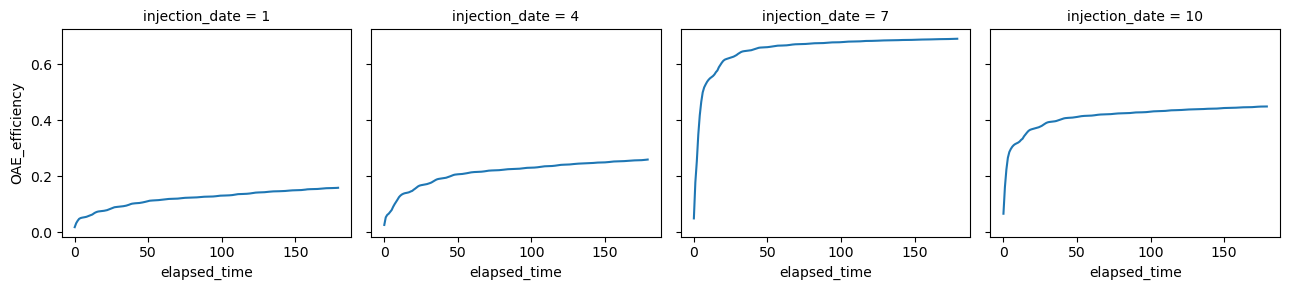

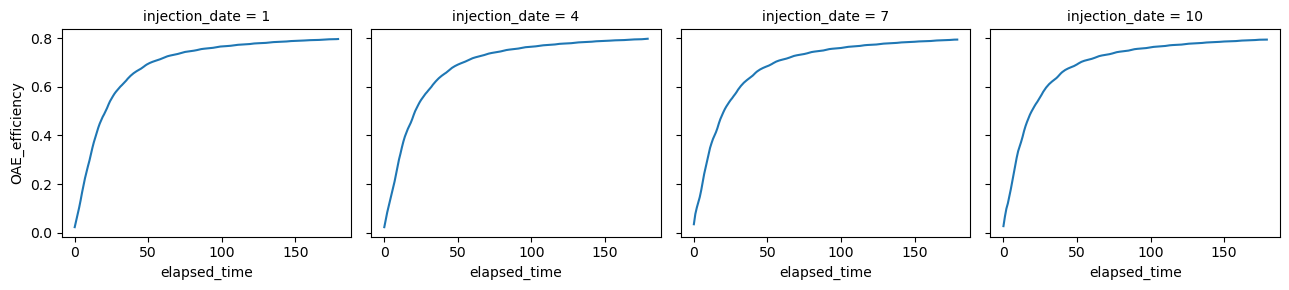

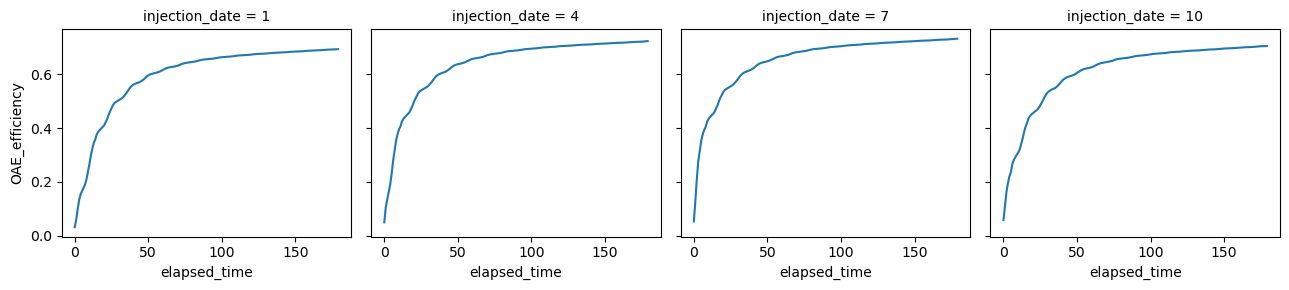

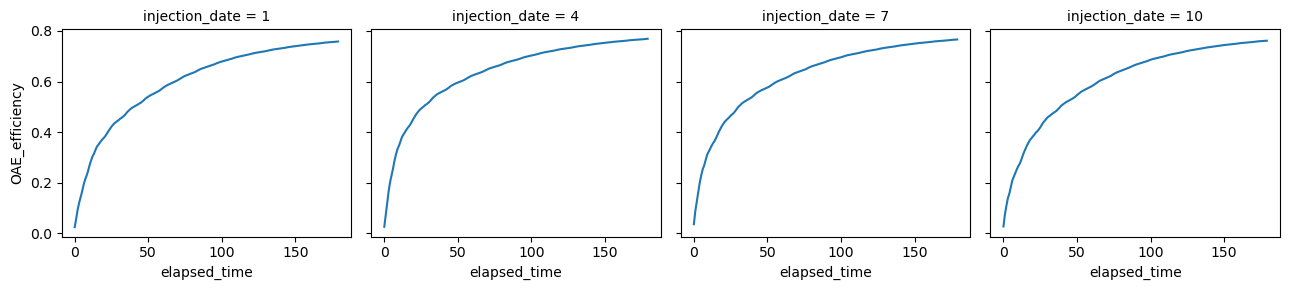

In [22]:
dset.isel(polygon_id=0).OAE_efficiency.plot(col='injection_date')
dset.isel(polygon_id=10).OAE_efficiency.plot(col='injection_date')
dset.isel(polygon_id=100).OAE_efficiency.plot(col='injection_date')
dset.isel(polygon_id=300).OAE_efficiency.plot(col='injection_date')